In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/EC523Project"
#!ls "/content/drive/Shared with me/EC523Project"

 523_Project_Status_Update.gdoc
 523_Project_Status_Update_Template.docx
 Augmented_data
 Augmented_data_original+3transforms
 AutoLiverCancerDetection.ipynb
 copy_transUnet.ipynb
'EC 523 Project.gdoc'
'EC 523 Project Proposal.gdoc'
 Figures.gdoc
'Group 5- 523 Deep Learning Project Presentation.gslides'
 Kvasir-SEG
 lits_df.csv
 lits_probe.csv
 lits_test.csv
 lits_train.csv
 Liver_Tumor
'Loss Func AutoLiverCancerDetection.ipynb'
'Resize_augmented(512x512x512)'
 SegmentationData
 TransUnet2.ipynb
 transUnet.ipynb
 transunet_model1_2.pth
 transunet_model1_state.pth
 unet_aspp_softmax_classweight123.pth
 unet_aspp_softmax_classweight.pth
 unet_aspp_softmax_dice+ce.pth
 unet_aspp_softmax_weight123_20_new.pth
'UNet++ AutoLiverCancerDetection.ipynb'
 VolumeData


# Load Data

In [2]:
import os
import glob
import cv2
import imageio

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [ ]:
# Define the path to the segmentation data directory in Google Drive
segmentation_data_path = "/content/drive/My Drive/EC523Project/SegmentationData/segmentations"
#segmentation_data_path = "/content/drive/Shared with me/EC523Project/SegmentationData/segmentations"

# Define the path to the volume data directory in Google Drive
volume_data_path = "/content/drive/My Drive/EC523Project/VolumeData"
#volume_data_path = "/content/drive/Shared with me/EC523Project/VolumeData"

In [ ]:
# Retrieve all .nii file paths from the segmentation_data_path
segmentation_files = [os.path.join(segmentation_data_path, f) for f in os.listdir(segmentation_data_path) if f.endswith('.nii')]

# Extract directory names and filenames from the segmentation file paths
segmentation_dirnames = [os.path.dirname(f) for f in segmentation_files]
segmentation_filenames = [os.path.basename(f) for f in segmentation_files]

# Create a DataFrame with the directory and filename information
segmentation_df = pd.DataFrame({
    'dirname': segmentation_dirnames,
    'filename': segmentation_filenames
})

# Sort the DataFrame based on filename in ascending order
segmentation_df = segmentation_df.sort_values(by=['filename'], ascending=True)

# Display the segmentation DataFrame
print("Segmentation Files:")
print(segmentation_df)

Segmentation Files:
                                                                 dirname  \
0    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
1    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
2    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
3    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
4    /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
..                                                                   ...   
126  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
127  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
128  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
129  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   
130  /content/drive/My Drive/EC523Project/SegmentationData/segmentations   

                 filename  
0      segmentation-0.nii  
1      segm

In [ ]:
# Initialize an empty list to store volume file paths
volume_files = []

# Iterate over each folder in the volume data path
for pt_folder in os.listdir(volume_data_path):
    pt_folder_path = os.path.join(volume_data_path, pt_folder)

    # Check if the current path is a directory
    if os.path.isdir(pt_folder_path):
        # Iterate over each file in the directory
        for volume_file in os.listdir(pt_folder_path):
            # If the file is a .nii file, append its path to the volume_files list
            if volume_file.endswith('.nii'):
                volume_files.append(os.path.join(pt_folder_path, volume_file))

# Extract directory names and filenames from the volume file paths
volume_dirnames = [os.path.dirname(f) for f in volume_files]
volume_filenames = [os.path.basename(f) for f in volume_files]

# Create a DataFrame with the directory and filename information
volume_df = pd.DataFrame({
    'dirname': volume_dirnames,
    'filename': volume_filenames
})

# Sort the DataFrame based on filename in ascending order
volume_df = volume_df.sort_values(by=['filename'], ascending=True)

# Display the volume DataFrame
print("\nVolume Files:")
print(volume_df)



Volume Files:
                                                        dirname  \
0    /content/drive/My Drive/EC523Project/VolumeData/volume_pt1   
1    /content/drive/My Drive/EC523Project/VolumeData/volume_pt1   
2    /content/drive/My Drive/EC523Project/VolumeData/volume_pt1   
81   /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
51   /content/drive/My Drive/EC523Project/VolumeData/volume_pt8   
..                                                          ...   
126  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
127  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
128  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
129  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   
130  /content/drive/My Drive/EC523Project/VolumeData/volume_pt6   

           filename  
0      volume-0.nii  
1      volume-1.nii  
2     volume-10.nii  
81   volume-100.nii  
51   volume-101.nii  
..              ...  
126   volume-95.nii  
127 

In [ ]:
# Combine segmentation_df and volume_df into a consolidated DataFrame
df_files = pd.concat([segmentation_df, volume_df], ignore_index=True)

# Create new columns to store mask directory and filename
df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

# Assuming you have 131 pairs of CT scans and their corresponding segmentations
for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    # Update mask_filename and mask_dirname where the filename matches the CT scan
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = segmentation_data_path

# Filter out rows that don't have a corresponding mask
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)

# Display the final DataFrame
df_files


,dirname,filename,mask_dirname,mask_filename
0,/content/drive/My Drive/EC523Project/VolumeData/volume_pt1,volume-0.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-0.nii
1,/content/drive/My Drive/EC523Project/VolumeData/volume_pt1,volume-1.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-1.nii
2,/content/drive/My Drive/EC523Project/VolumeData/volume_pt1,volume-10.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-10.nii
3,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-100.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-100.nii
4,/content/drive/My Drive/EC523Project/VolumeData/volume_pt8,volume-101.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-101.nii
...,...,...,...,...
126,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-95.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-95.nii
127,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-96.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-96.nii
128,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-97.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-97.nii
129,/content/drive/My Drive/EC523Project/VolumeData/volume_pt6,volume-98.nii,/content/drive/My Drive/EC523Project/SegmentationData/segmentations,segmentation-98.nii


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [ ]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [ ]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


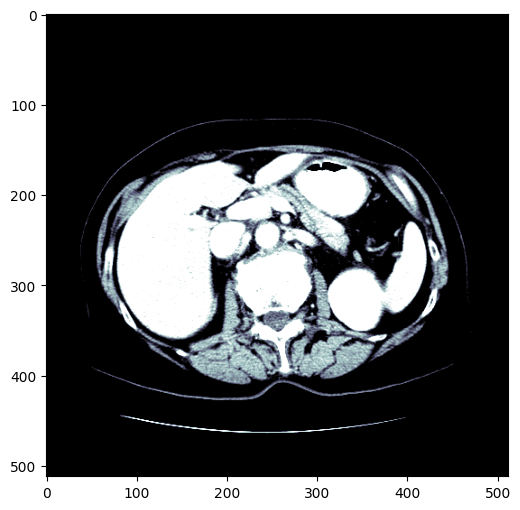

In [ ]:
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

# Data Augmentation w/ TorchIO

In [3]:
# Install necessary libraries. run only once
!pip install torchio==0.18.90 --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scikit-image --quiet
!curl -s -o colormap.txt https://raw.githubusercontent.com/thenineteen/Semiology-Visualisation-Tool/master/slicer/Resources/Color/BrainAnatomyLabelsV3_0.txt
!curl -s -o slice_7t.jpg https://www.statnews.com/wp-content/uploads/2019/08/x961_unsmoothed_cropped-copy-768x553.jpg
!curl -s -o slice_histo.jpg https://upload.wikimedia.org/wikipedia/commons/6/64/Medulloepithelioma_Histology.jpg
!curl -s -o vhp.zip https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Sample-Data/Six%20slices%20from%20the%20Visible%20Male.zip
!unzip -o vhp.zip > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 24.7 MB/s eta 0:00:00


In [4]:
import torchio as tio
from torchio import AFFINE, DATA, PATH, TYPE, STEM


In [ ]:
# Put together the training set
subjects_list = []
for index, row in df_files.iterrows():
    subject_dict = {
        'ct': tio.ScalarImage(path=row['dirname'] + '/' + row['filename']),
        'mask': tio.LabelMap(path=row['mask_dirname'] + '/' + row['mask_filename'])
    }
    subjects_list.append(tio.Subject(subject_dict))

dataset = tio.SubjectsDataset(subjects_list)

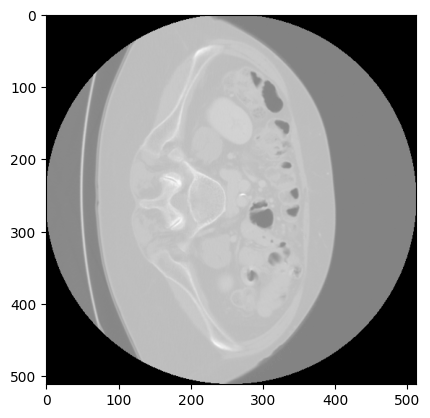

In [ ]:
import matplotlib.pyplot as plt
subject = dataset[0]
ct_image_tensor = subject['ct'][tio.DATA]
ct_image_array = ct_image_tensor.numpy()
ct_slice = ct_image_array[0, :, :, ct_image_array.shape[3] // 2]

plt.imshow(ct_slice, cmap='gray')
plt.show()

**Augment the dataset**

In [ ]:
get_foreground = tio.ZNormalization.mean

transform = tio.Compose([
    tio.RandomAnisotropy(p=0.25),  # make images look anisotropic 25% of times


    # tio.HistogramStandardization(
    #     landmark_location,
    #     masking_method=get_foreground),        # standardize histogram of foreground, if we can find the landmarks
    # tio.ZNormalization(
    #     masking_method=get_foreground),        # zero mean, unit variance of foreground

    tio.OneOf({
        tio.RandomBlur(p=0.25): 0.3,                    # blur 25% of times
        tio.RandomNoise(p=0.25): 0.3,                   # Gaussian noise 25% of times
        tio.ZNormalization(masking_method=get_foreground): 0.3,        # zero mean, unit variance of foreground
    }),
    # tio.RandomFlip(axes=(0, 1, 2), p=0.5),  # Random flip

    tio.OneOf({                             # one of the spatial
        tio.RandomAffine(): 0.75,
        tio.RandomElasticDeformation(): 0.25,
    }, p=0.8),
    tio.RandomBiasField(p=0.3),  # Random bias field

    tio.OneOf({
      tio.RandomSpike(): 0.3,  # Random spike
      tio.RandomGhosting(intensity=1.5): 0.3,  # Random ghosting artifact
      tio.RandomMotion(num_transforms=6, image_interpolation='nearest'): 0.3,  # Random motion artifact
    }),
    tio.ToCanonical(),
    tio.Resample((1,1,1), image_interpolation='nearest'),
    tio.CropOrPad((350, 350, 350)),
])

transform_resize = tio.Compose([
  tio.ToCanonical(),
  tio.Resample((1,1,1), image_interpolation='nearest'),
  tio.CropOrPad((350, 350, 350)),
])

#indices_to_remove = [3,6,29,36,74,75,77,78,79]
# augmented_dataset = tio.SubjectsDataset(subjects_list[0:3], transform=transform) + tio.SubjectsDataset(subjects_list[4:6], transform=transform) + tio.SubjectsDataset(subjects_list[7:29], transform=transform) + tio.SubjectsDataset(subjects_list[30:36], transform=transform) + tio.SubjectsDataset(subjects_list[37:74], transform=transform) + tio.SubjectsDataset([subjects_list[76]], transform=transform) + tio.SubjectsDataset(subjects_list[80:100], transform=transform)
augmented_dataset = tio.SubjectsDataset(subjects_list[:100], transform=transform)

val_dataset = tio.SubjectsDataset(subjects_list[100:], transform=transform_resize)

**Save Augmented Data**

In [ ]:
import os
augmented_data_dir = "/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)"
os.makedirs(augmented_data_dir, exist_ok=True)

In [ ]:
import pickle

# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_2.pkl'

# Open the file in write-binary mode and save the dataset
with open(file_path, 'wb') as file:
    pickle.dump(augmented_dataset, file)

# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_val_2.pkl'

# Open the file in write-binary mode and save the dataset
with open(file_path, 'wb') as file:
    pickle.dump(val_dataset, file)

# Training and Test Datasets

**Load the Data**

In [ ]:
import torch
import torchio as tio
from torchio import AFFINE, DATA, PATH, TYPE, STEM


In [5]:
import pickle

# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_filter.pkl'
# Open the file in read-binary mode and load the dataset
with open(file_path, 'rb') as file:
    augmented_dataset = pickle.load(file)


In [ ]:
i = -1
# data = []
while i < len(val_dataset):
  i += 1
  try:
    subject = val_dataset[i]
    ct_image_tensor = subject['ct'][tio.DATA]
    ct_mask_tensor = subject['mask'][tio.DATA]
    # if ct_image_tensor.shape == torch.Size([1, 350, 350, 350]) and ct_mask_tensor.shape == torch.Size([1, 350, 350, 350]):
    print(i)
  except:
    print("Fail")

# train_data = tio.SubjectsDataset(data)
# file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_2_edit.pkl'
# with open(file_path, 'wb') as file:
#     pickle.dump(train_data, file)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Fail
Fail
17
18
19
20
21
22
23
24
25
26
Fail
Fail
29
Fail
Fail


In [ ]:
# indices_to_remove = [3,4,6,29,36,74,75,77,78,79]
dataset = tio.SubjectsDataset(subjects_list[0:15], transform=transform_resize)
dataset += tio.SubjectsDataset(subjects_list[17:27], transform=transform_resize)
dataset += tio.SubjectsDataset(subjects_list[29:30], transform=transform_resize)
# dataset += tio.SubjectsDataset(subjects_list[30], transform=transform_resize)
# dataset += tio.SubjectsDataset(subjects_list[37:74], transform=transform_resize)
# dataset += tio.SubjectsDataset(subjects_list[76:77], transform=transform_resize)
# dataset += tio.SubjectsDataset(subjects_list[80:100], transform=transform_resize)
# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_val_2_filter.pkl'

# Open the file in write-binary mode and save the dataset
with open(file_path, 'wb') as file:
    pickle.dump(dataset, file)

dict_keys(['data', 'affine', 'path', 'stem', 'type'])


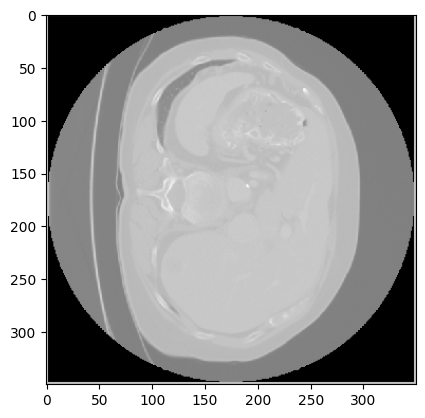

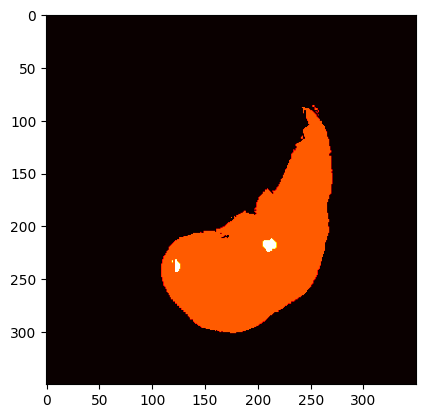

In [ ]:
import matplotlib.pyplot as plt

subject = augmented_dataset[1]
# print(type(subject))

# Access the CT image tensor in the first subject
ct_image_tensor = subject['ct'][tio.DATA]
ct_mask_tensor = subject['mask'][tio.DATA]

print(subject['mask'].keys())
# print(ct_mask_tensor.shape)

# Convert the tensor to a NumPy array
ct_image_array = ct_image_tensor.numpy()
ct_mask_array = ct_mask_tensor.numpy()

# Select a 2D slice from the 3D CT image to display
ct_slice = ct_image_array[0, :, :, ct_image_array.shape[3] // 2]
ct_slice2 = ct_mask_array[0, :, :, ct_mask_array.shape[3] // 2]

# Display the slice using Matplotlib
plt.imshow(ct_slice, cmap='gray')
plt.show()
plt.imshow(ct_slice2, cmap='hot')
plt.show()


# UNet++

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic block for U-Net++
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.residual_conv = None

    def forward(self, x):
        x = x.float()
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.residual_conv:
            residual = self.residual_conv(residual)
        out += residual  # Add the residual connection
        out = self.relu(out)
        return out

# UNet++ architecture without ASPP
class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(UNetPlusPlus, self).__init__()
        out_channels = [64, 128, 256, 512, 1024]

        # Backbone
        self.conv0_0 = ConvBlock(in_channels, out_channels[0], out_channels[0])
        self.conv1_0 = ConvBlock(out_channels[0], out_channels[1], out_channels[1])
        self.conv2_0 = ConvBlock(out_channels[1], out_channels[2], out_channels[2])
        self.conv3_0 = ConvBlock(out_channels[2], out_channels[3], out_channels[3])
        self.conv4_0 = ConvBlock(out_channels[3], out_channels[4], out_channels[4])

        # Skip pathways
        self.conv0_1 = ConvBlock(out_channels[0]+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_1 = ConvBlock(out_channels[1]+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_1 = ConvBlock(out_channels[2]+out_channels[3], out_channels[2], out_channels[2])
        self.conv3_1 = ConvBlock(out_channels[3]+out_channels[4], out_channels[3], out_channels[3])

        self.conv0_2 = ConvBlock(out_channels[0]*2+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_2 = ConvBlock(out_channels[1]*2+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_2 = ConvBlock(out_channels[2]*2+out_channels[3], out_channels[2], out_channels[2])

        self.conv0_3 = ConvBlock(out_channels[0]*3+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_3 = ConvBlock(out_channels[1]*3+out_channels[2], out_channels[1], out_channels[1])

        self.conv0_4 = ConvBlock(out_channels[0]*4+out_channels[1], out_channels[0], 3)

        # Pooling and up-sampling
        self.pool = nn.MaxPool2d(2, 2)
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Backbone
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Input = previous conv + up-sample lower conv
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up_sample(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, F.pad(self.up_sample(x2_0), (0,1,0,1), "constant", 0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, F.pad(self.up_sample(x3_0), (0,1,0,1), "constant", 0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, F.pad(self.up_sample(x4_0), (0,1,0,1), "constant", 0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up_sample(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, F.pad(self.up_sample(x2_1), (0,1,0,1), "constant", 0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, F.pad(self.up_sample(x3_1), (0,1,0,1), "constant", 0)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up_sample(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, F.pad(self.up_sample(x2_2), (0,1,0,1), "constant", 0)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up_sample(x1_3)], 1))

        return x0_4

# Loss

In [7]:
!pip install torch torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.1 MB/s eta 0:00:00


In [8]:
from numpy.ma.core import innerproduct
#dice loss definition
import torch
import torch.nn as nn
import torch.nn.functional as F

# class DiceLoss(nn.Module): #just set this as the criterion, like criterion = DiceLoss()
#   def __init__(self):
#     super(DiceLoss, self).__init__()

#   def forward(self, input, target):
#     smooth=1e-5 #this is just to avoid divide by 0
#     # target = target.resize_(input.shape)
#     input_flat = input.view(-1) #flatten input
#     target_flat = target.view(-1) #flatten true labels
#     intersection = (input_flat*target_flat).sum()
#     return 1 - ((2.0*intersection+smooth)/((input_flat**2).sum()+(target_flat**2).sum()+smooth))

# class DiceLoss(nn.Module): #just set this as the criterion, like criterion = DiceLoss()
#   def __init__(self):
#     super(DiceLoss, self).__init__()

#   def forward(self, input, target):
#     smooth=1e-5 #this is just to avoid divide by 0
#     dice = 0.0
#     total = 0
#     unique_classes = torch.unique(target[:,0,:,:])  # Unique classes in the target for each channel
#     channels = input.shape[1]
#     # if len(unique_classes) == 1:
#         # input_flat = input.view(-1)  # Flatten input for the channel
#         # target_flat = target.view(-1)  # Flatten target for the class
#         # intersection = torch.sum(input_flat * target_flat)
#         # dice_class = 1-(2.0 * intersection + smooth) / (torch.sum(input_flat) + torch.sum(target_flat) + smooth)
#         # dice += dice_class
#         # total += 1

#     # else:
#     if len(unique_classes) > 1:
#       for channel in range(channels):
#         for class_idx in unique_classes[1:]:
#             idx = float(class_idx.item())
#             input_flat = (input[:,channel,:,:] == idx).float().view(-1)  # Flatten input for the channel
#             target_flat = (target[:,0,:,:] == idx).float().view(-1)  # Flatten target for the class
#             intersection = torch.sum(input_flat * target_flat)
#             dice_class = 1-(2.0 * intersection + smooth) / (torch.sum(input_flat) + torch.sum(target_flat) + smooth)
#             dice += dice_class
#         total += len(unique_classes)-1
#     dice /= total
#     return dice

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1e-5  # this is just to avoid divide by 0
        dice = 0.0
        total = 0
        unique_classes = torch.unique(target)
        channels = input.shape[1]

        if len(unique_classes) > 1:
            for class_idx in unique_classes:
                idx = float(class_idx.item())
                for channel in range(channels):
                    input_flat = (input[:, channel, :, :] == idx ).float().view(-1)
                    target_flat = (target == idx).float().view(-1)
                    intersection = torch.sum(input_flat * target_flat)
                    dice_class = 1 - (2.0 * intersection + smooth) / (torch.sum(input_flat) + torch.sum(target_flat) + smooth)
                    dice += dice_class
                total += 1

        dice /= total
        # print("DICE", dice)
        return dice

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.3, class_weights=None):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()
        self.dice_weight = dice_weight

    def forward(self, input, target):
        dice = self.dice_loss(input.float(), target.float())
        ce_target = F.one_hot(target.squeeze(1).long(), num_classes=3).permute(0,3,1,2)
        ce = self.ce_loss(input.float(), ce_target.float())
        combined = (self.dice_weight * dice) + ((1 - self.dice_weight) * ce)
        return combined

def iou(pred_masks, true_masks):
    num_classes = pred_masks.shape[1]
    iou_sum = 0.0
    pred_probs = torch.softmax(pred_masks, dim=1)
    # true_mask_one_hot = F.one_hot(true_masks.squeeze(1).long(), num_classes=3).permute(0, 3, 1, 2).float()

    for class_idx in range(num_classes):
        pred_mask = (torch.argmax(pred_probs.float(), dim=1) == class_idx).float()
        # true_mask = true_masks[:, class_idx]
        # true_mask_one_hot = F.one_hot(true_mask, num_classes=3).permute(0, 3, 1, 2).float()
        # print(pred_mask.shape)
        intersection = torch.logical_and(pred_mask, (true_masks[:,0,:,:]==class_idx).float()).sum()
        union = torch.logical_or(pred_mask, (true_masks[:,0,:,:]==class_idx).float()).sum()
        iou = intersection / union
        iou_sum += iou

    mean_iou = iou_sum / num_classes
    return mean_iou

# Training and Testing

In [9]:
loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=4, shuffle=True)

In [ ]:
num_classes = 3  # 0, 1, and potentially 2
out = torch.tensor([[0,0,1],[1,0,1],[1,2,2]])
print(F.one_hot(out, num_classes=3))
out_indices = out.to(torch.int64)
print(F.one_hot(out_indices, num_classes=3))
# out_encode = torch.zeros(out.shape[0], num_classes, *out.shape[1:], device=out.device)
# out_encode = out_encode.scatter(1, out_indices.unsqueeze(1), 1)
# print(out_encode)
# print(out_encode.shape)

In [10]:
#training and testing functions
import torchmetrics
from torchvision import ops
import torch.optim as optim

def train_model(model, train_loader, num_epochs, optimizer, criterion, device):
  try:
    for epoch in range(num_epochs):
      model.train()
      total_loss = 0.0
      total_iou = 0.0
      num_samples = 0
      # try:
      for batch_idx, batch in enumerate(train_loader):
        inputs, labels = batch['ct']['data'][:, :, :, batch['ct']['data'].shape[3] // 2].to(device), batch['mask']['data'][:, :, :, batch['mask']['data'].shape[3] // 2].to(device)
        optimizer.zero_grad()
        # print("right before")
        out = model(inputs)
        # print("pass")
        loss = criterion(out, labels)
        # loss.mean()
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()
        with torch.no_grad():
          iou_val = iou(out, labels)
          total_iou += iou_val * inputs.size(0)
          num_samples += inputs.size(0)

        total_loss += loss.item() * inputs.size(0)
        if batch_idx % 100 == 0:
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, IoU: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), iou_val))
      average_loss = total_loss/num_samples
      average_iou = total_iou/num_samples
      print('Epoch [{}/{}], Average Loss: {:.4f}, Average IoU: {:.4f}'
            # .format(epoch+1, num_epochs, average_loss))
            .format(epoch+1, num_epochs, average_loss, average_iou))
    torch.save(model, "unet++_softmax_weight124_30_dice+ce.pth")
    torch.save(model, "/content/drive/My Drive/EC523Project/unet++_softmax_weight124_30_dice+ce.pth")
  except:
    # Printing the error message
    # print(e)
    torch.save(model, "unet++_softmax_weight124_30_dice+ce.pth")
    torch.save(model, "/content/drive/My Drive/EC523Project/unet++_softmax_weight124_30_dice+ce.pth")

def test_model(model, val_loader, criterion):
  model.eval()
  total_loss = 0.0
  total_iou = 0.0
  num_samples = 0
  with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
      inputs, labels = batch['ct']['data'][:, :, :, batch['ct']['data'].shape[3] // 2].to(device), batch['mask']['data'][:, :, :, batch['mask']['data'].shape[3] // 2].to(device)
      out = model(inputs)
      loss = criterion(out, labels)
      iou_val = iou(out, labels)
      total_iou += iou_val * inputs.size(0)
      total_loss += loss.item() * inputs.size(0)
      num_samples += inputs.size(0)
    average_loss = total_loss/num_samples
    average_iou = total_iou/num_samples
    print('Test Loss: {:.4f}, Test IoU: {:.4f}'.format(average_loss, average_iou))

In [ ]:
import torch
import torch.nn.functional as F

# Assuming your tensor is named 'tensor'
input_tensor = torch.randn(2)  # Replace this with your tensor

resized_tensor = input_tensor.resize_(158)

#245000
print(resized_tensor.shape)
print(resized_tensor.view(-1).shape)

In [ ]:
#train the model
input_channels = 1 #change
num_classes = 3 #change
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetPlusPlus(num_classes, input_channels) #can change deep_supervision
class_weights = torch.tensor([1, 2, 4])  # Define weights for each class
class_weights = class_weights.to(device)
criterion = CombinedLoss(dice_weight=0.3, class_weights=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001) #can change optimizer
model = model.to(device)
num_epochs = 30
train_model(model, loader, num_epochs, optimizer, criterion, device)
# torch.save(model, "/content/drive/My Drive/EC523Project/unet_aspp_softmax_classweight123_20.pth")

Epoch [1/30], Step [1/23], Loss: 1.7857, IoU: 0.3057
Epoch [1/30], Average Loss: 1.1561, Average IoU: nan
Epoch [2/30], Step [1/23], Loss: 1.0176, IoU: nan
Epoch [2/30], Average Loss: 1.0877, Average IoU: nan
Epoch [3/30], Step [1/23], Loss: 1.1627, IoU: 0.2967
Epoch [3/30], Average Loss: 1.1127, Average IoU: nan
Epoch [4/30], Step [1/23], Loss: 1.1477, IoU: 0.2976
Epoch [4/30], Average Loss: 1.0899, Average IoU: nan
Epoch [5/30], Step [1/23], Loss: 1.1049, IoU: 0.3052


In [ ]:
# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset_val_2_filter.pkl'
# Open the file in read-binary mode and load the dataset
with open(file_path, 'rb') as file:
    val_dataset = pickle.load(file)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/My Drive/EC523Project/unet_aspp_softmax_weight123_20_new.pth"
trained_model = torch.load(model_path)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)
criterion = CombinedLoss()

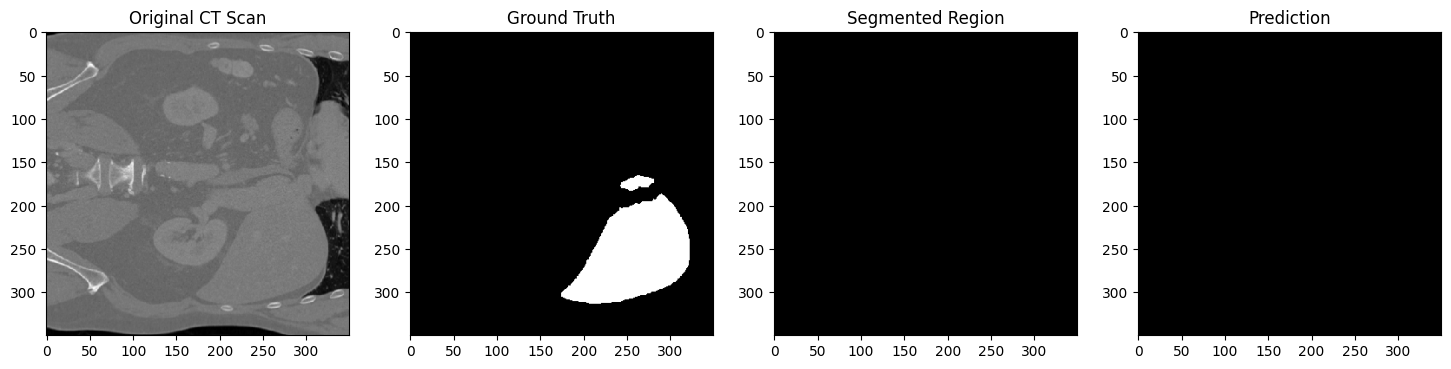

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

def visualize_segmentation(model, data_loader, device, threshold=0.5):
  # model.eval()
  for batch_idx, batch in enumerate(data_loader):
    inputs, labels = batch['ct']['data'][:, :, :, batch['ct']['data'].shape[3] // 2].to(device), batch['mask']['data'][:, :, :, batch['mask']['data'].shape[3] // 2].to(device)
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
      predictions = model(inputs)

    # segmented_mask = (predictions > 0.5).float()
    segmented_mask = torch.argmax(torch.softmax(predictions.float(),dim=1), dim=1).float()
    # segmented_mask = torch.argmax(torch.softmax(predictions.float(),dim=1), dim=1).float()
    inputs = inputs.cpu().squeeze().numpy()
    labels = labels.cpu().squeeze().numpy()

    # segmented_mask = segmented_mask[:, 0, :, :]
    segmented_mask = segmented_mask.cpu().squeeze().numpy()

    predictions = predictions.cpu().squeeze().numpy()

    # print(torch.softmax(predictions.float(),dim=1).float())
    # print(inputs.shape)     # [2, 350, 350]
    # print(labels.shape)     # [2, 350, 350]
    # print(segmented_mask.shape)   # [2, 10, 350, 350]
    # print(np.unique(labels))
    # print("PREDICT", predictions)
    # print("MASK", segmented_mask)

    plt.figure(figsize=(18,6))
    plt.subplot(1, 4, 1)
    plt.imshow(inputs[0], cmap='gray')
    plt.title('Original CT Scan')
    plt.subplot(1, 4, 2)
    plt.imshow(labels[0], cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1, 4, 3)
    plt.imshow(segmented_mask[0], cmap='gray')
    plt.title('Segmented Region')
    plt.subplot(1, 4, 4)
    plt.imshow(predictions[0][1], cmap='gray')
    plt.title('Prediction')
    # plt.subplot(1, 5, 5)
    # plt.imshow(segmented_mask[0][2], cmap='gray')
    # plt.title('Segmented Region')
    plt.show()
    break

visualize_segmentation(model, loader, device)

In [ ]:
#test the model
test_model(trained_model, val_loader, criterion)    #dice_ce: loss=1, iou=0.234,
                                                    #classweight-122: loss=1, iou=0.1936 but better
                                                    #classweight-123: loss=0.9683, iou=0.2342
                                                    #new: loss=

RuntimeError: ignored